In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.sparse import bmat
from numpy.linalg import solve


In [110]:
def u_exact(x, omega):
    A = np.array([
        [1.0, 1.0],
        [np.exp(omega), np.exp(-omega)]
    ])
    b = np.array([
        -2.0 / omega**4,
        -1.0 / omega**2 - 2.0 / omega**4
    ])
    C1, C2 = solve(A, b)

    return (
        C1 * np.exp(omega * x)
        + C2 * np.exp(-omega * x)
        + x**2 / omega**2
        + 2.0 / omega**4
    )

In [111]:
omega = 5.0

In [112]:
def psi_i_0_left(x, x_im1, x_i):
    return ((x - x_im1)**2 * (3*x_i - 2*x - x_im1)) / (x_i - x_im1)**3

def psi_i_0_right(x, x_i, x_ip1):
    return ((x_ip1 - x)**2 * (2*x + x_ip1 - 2*x_i)) / (x_ip1 - x_i)**3


def psi_i_1_left(x, x_im1, x_i):
    return -((x - x_im1)**2 * (x_i - x)) / (x_i - x_im1)**2

def psi_i_1_right(x, x_i, x_ip1):
    return ((x_ip1 - x_i)**2 * (x - x_i)) / (x_ip1 - x_i)**2


def dpsi_i_0_left(x, x_im1, x_i):
    h = x_i - x_im1
    return (6*(x - x_im1)*(x_i - x)) / h**3

def dpsi_i_0_right(x, x_i, x_ip1):
    h = x_ip1 - x_i
    return -(6*(x_ip1 - x)*(x - x_i)) / h**3


def dpsi_i_1_left(x, x_im1, x_i):
    h = x_i - x_im1
    return -((2*(x - x_im1)*(x_i - x) - (x - x_im1)**2)) / h**2

def psi_i_1_right(x, x_i, x_ip1):
    h = x_ip1 - x_i
    return (x - x_i) * (x_ip1 - x)**2 / h**2


Assembled system:
  (np.int32(0), np.int32(0))	240.2
  (np.int32(0), np.int32(1))	-119.975
  (np.int32(0), np.int32(100))	-0.10024999999999999
  (np.int32(1), np.int32(0))	-119.975
  (np.int32(1), np.int32(1))	240.2
  (np.int32(1), np.int32(2))	-119.97500000000002
  (np.int32(1), np.int32(99))	0.10024999999999999
  (np.int32(1), np.int32(100))	-4.0657581468206415e-21
  (np.int32(1), np.int32(101))	-0.10024999999999999
  (np.int32(2), np.int32(1))	-119.97500000000002
  (np.int32(2), np.int32(2))	240.2
  (np.int32(2), np.int32(3))	-119.97499999999997
  (np.int32(2), np.int32(100))	0.10024999999999999
  (np.int32(2), np.int32(101))	8.131516293641283e-21
  (np.int32(2), np.int32(102))	-0.10024999999999999
  (np.int32(3), np.int32(2))	-119.97499999999997
  (np.int32(3), np.int32(3))	240.19999999999993
  (np.int32(3), np.int32(4))	-119.97499999999997
  (np.int32(3), np.int32(101))	0.10024999999999999
  (np.int32(3), np.int32(103))	-0.10024999999999999
  (np.int32(4), np.int32(3))	-119.974999

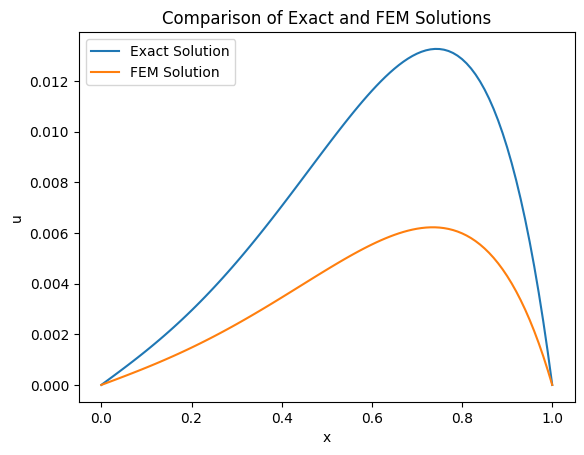

In [ ]:
def helmholtz_c1(x, omega):
    N = len(x) - 1

    A00 = lil_matrix((N-1, N-1))
    A01 = lil_matrix((N-1, N-1))
    A10 = lil_matrix((N-1, N-1))
    A11 = lil_matrix((N-1, N-1))

    b0 = np.zeros(N-1)
    b1 = np.zeros(N-1)


    for i in range(1, N):
        k = i - 1
        xm, xi, xp = x[i-1], x[i], x[i+1]

        A00[k, k] = omega**2 * 2*(xp - xm)/5 +  6*(1/(xi-xm) + 1/(xp-xi))/5

        if k > 0:
            A00[k, k-1] = omega**2 * (xi-xm)/10 - 6/(5*(xi-xm))
        if k < N-2:
            A00[k, k+1] = omega**2 * (xp-xi)/10 - 6/(5*(xp-xi))

        A01[k, k] = ((xp-xi)**2 - (xi-xm)**2)/10
        A10[k, k] = A01[k, k]

        if k > 0:
            A01[k, k-1] = (omega**2 * (xi-xm)**2 + 1)/10
            A10[k, k-1] = -(omega**2 * (xp-xi)**2 + 1)/10
        if k < N-2:
            A01[k, k+1] = -(omega**2 * (xp-xi)**2 + 1)/10
            A10[k, k+1] = (omega**2 * (xi-xm)**2 + 1)/10

        A11[k, k] = (omega**2 * (xp-xi)**3 + (xi-xm)**3)/15 + (xp-xm)/3
        if k > 0:
            A11[k, k-1] = -omega**2 * (xi-xm)**3/30 + (xi-xm)/6
        if k < N-2:
            A11[k, k+1] = -omega**2 * (xp-xi)**3/30 + (xp-xi)/6

        if k > 0:
            b0[k] += (
                (xi-xm)*(3*xm**2 + 4*xm*xi + 8*xi**2)
                + (xp-xi)*(8*xi**2 + 4*xi*xp + 3*xp**2)
            )/60

            b1[k] += (
                (xi-xm)**2*(xm**2 + 2*xm*xi + 3*xi**2)
                - (xp-xi)**2*(3*xi**2 + 2*xi*xp + xp**2)
            )/60

    A = bmat([[A00, A01],
              [A10, A11]], format="csr")
    b = np.hstack([b0, b1])

    z = spsolve(A, b)

    z0 = np.zeros(N+1)
    z1 = np.zeros(N+1)
    z0[1:-1] = z[:N-1]
    z1[1:-1] = z[N-1:]

    return z0, z1

def uh_eval(xe, x, z0, z1):
    N = len(x) - 1
    val = 0.0

    for i in range(1, N):
        xm, xi, xp = x[i-1], x[i], x[i+1]

        if xm <= xe <= xi:
            val += z0[i] * psi_i_0_left(xe, xm, xi)
            val += z1[i] * psi_i_1_left(xe, xm, xi)
        elif xi <= xe <= xp:
            val += z0[i] * psi_i_0_right(xe, xi, xp)
            val += z1[i] * psi_i_1_right(xe, xi, xp)

    return val

# plot u_exact and u_approx
n = 100

xx = np.linspace(0, 1, n+1)
z0, z1 = helmholtz_c1(xx, omega)
u_h = np.array([uh_eval(i, xx, z0, z1) for i in xx])
u_exact = u_exact(xx, omega)

plt.plot(xx, u_exact, label="Exact Solution")
plt.plot(xx, u_h, label="FEM Solution")
plt.legend()
plt.xlabel("x")
plt.ylabel("u")
plt.title("Comparison of Exact and FEM Solutions")
plt.show()
